# 1. Contextualização

O dataset [Flight Price Prediction](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) disponibilizado por [Shubham Bathwal](https://www.kaggle.com/shubhambathwal) contém dados de reservas aéreas obtidas do website "Easy My Trip". Os dados cobrem o período de 11 de Fevereiro até 31 de Março de 2022, com 300261 registros. 

### Features
|Coluna|Descrição|
|-------|--------|
|airline|A linha aérea do voo|
|flight|O código de identificação do voo|
|source_city|A cidade de onde o voo está partindo|
|departure_time|Período do dia em qual o voo partiu|
|stops|Número de paradas entre a partida e o destino|
|arrival_time|Período do dia em que o voo chegou|
|destination_city|A cidade destino do voo|
|class|Classe do voo|
|duration|Duração em horas do voo|
|days_left|Diferença entre o dia da viagem e da reserva|
|price|Preço da passagem|

## 1.1. Metas e objetivos

Este projeto tem objetivo de responder algumas perguntas de negócio e criar um modelo de Machine Learning para predição de preços de voos.

### Perguntas de negócio
1. Preço varia de acordo com a Linha Aérea? e com a Classe?
2. Como os preços das passagens são afetados, entre 1 e 2 dias antes da viagem?
3. O preço muda de acordo com o período do dia para chegada e partida?
4. O preço muda de acordo com o destino de partida e chegada?

# 2. Preparação do ambiente

## 2.1. Importação das bibliotecas e carregamento dos dados

In [87]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Machine Learning
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set2')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [88]:
df = pd.read_csv("../data/raw/Clean_Dataset.csv")

## 2.2. Qualidade dos dados

In [89]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 300153 linhas e 12 colunas.


In [90]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 8 colunas categóricas.
O dataset possui: 4 colunas numéricas.


In [91]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [92]:
df.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


# 3. Exploratory Data Analysis

## 3.1. Estatísticas descritivas

In [94]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.22,7.19,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.00,13.56,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.66,22697.77,1105.00,4783.00,7425.00,42521.00,123071.00


- Existe assimetria em ``price``, como a média é maior que a mediana é uma assimetria positiva;
- ``days_left`` tem uma distribuição normal;
- ``duration`` possui também assimetria positiva.

## 3.2. Dados nulos

In [95]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

## 3.3. O comportamento da variável alvo

In [96]:
print(f"Assimetria: {df.price.skew()}")
print(f"Curtose: {df.price.kurt()}")

Assimetria: 1.0613772532064343
Curtose: -0.3962927186960772


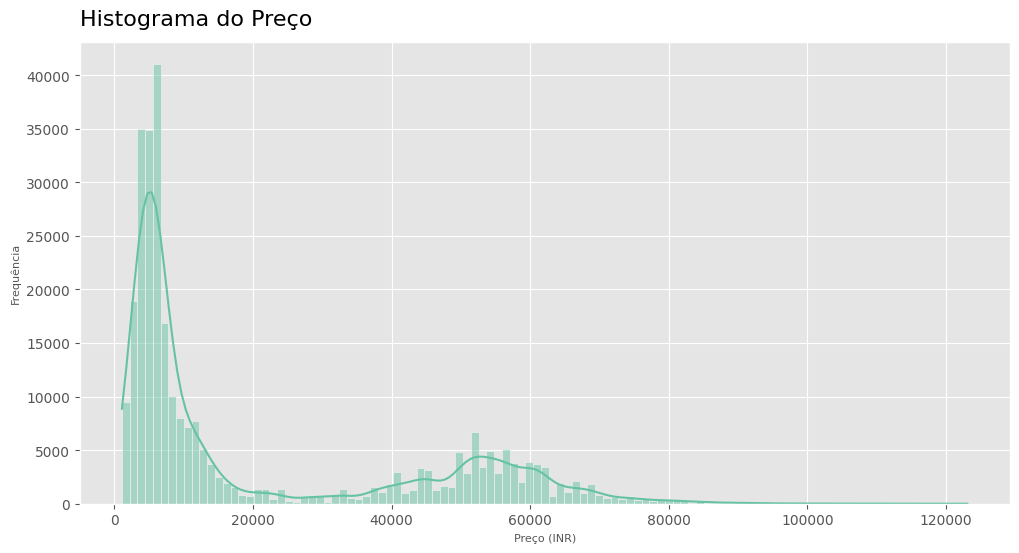

In [97]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.price, kde = True)
ax.set_title('Histograma do Preço', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Preço (INR)', fontsize = 8)
ax.set_ylabel('Frequência', fontsize = 8)
plt.show()

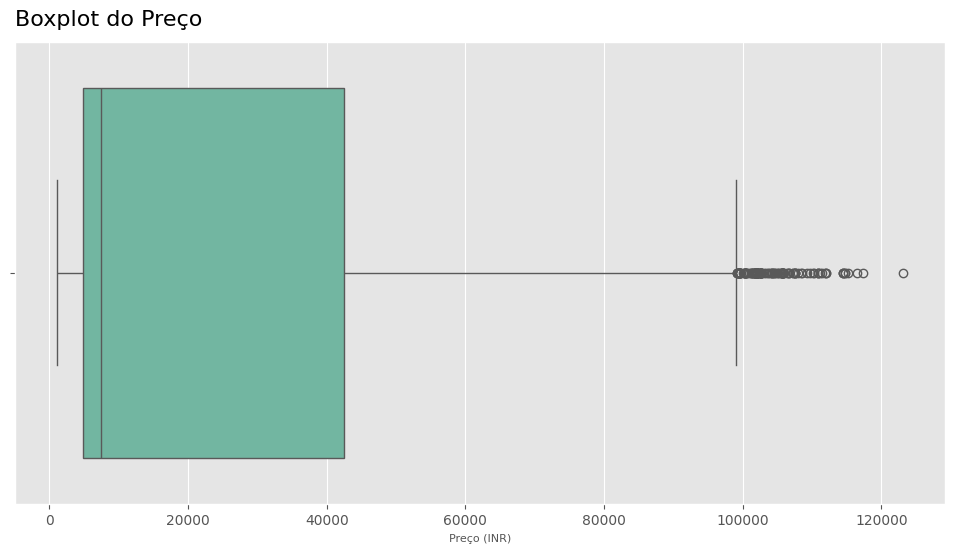

In [98]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(df, x = df.price)
ax.set_title('Boxplot do Preço', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Preço (INR)', fontsize = 8)
plt.show()

### Target, features e as perguntas de negócio

#### 1. Preço varia de acordo com a Linha Aérea? e com a Classe?

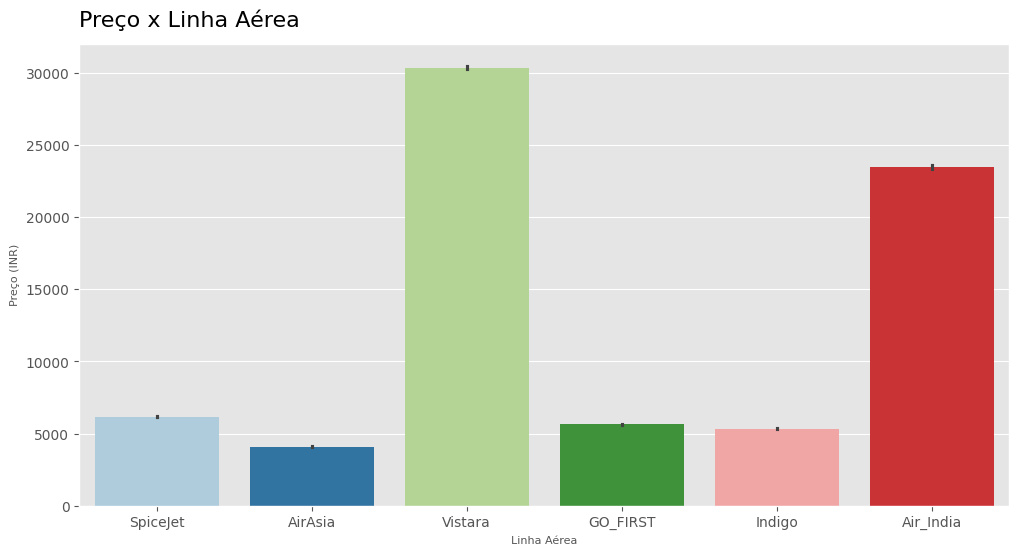

In [99]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df, x = df.airline, y = df.price, palette='Paired')
ax.set_title('Preço x Linha Aérea', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Linha Aérea', fontsize = 8)
ax.set_ylabel('Preço (INR)', fontsize = 8)
plt.show()

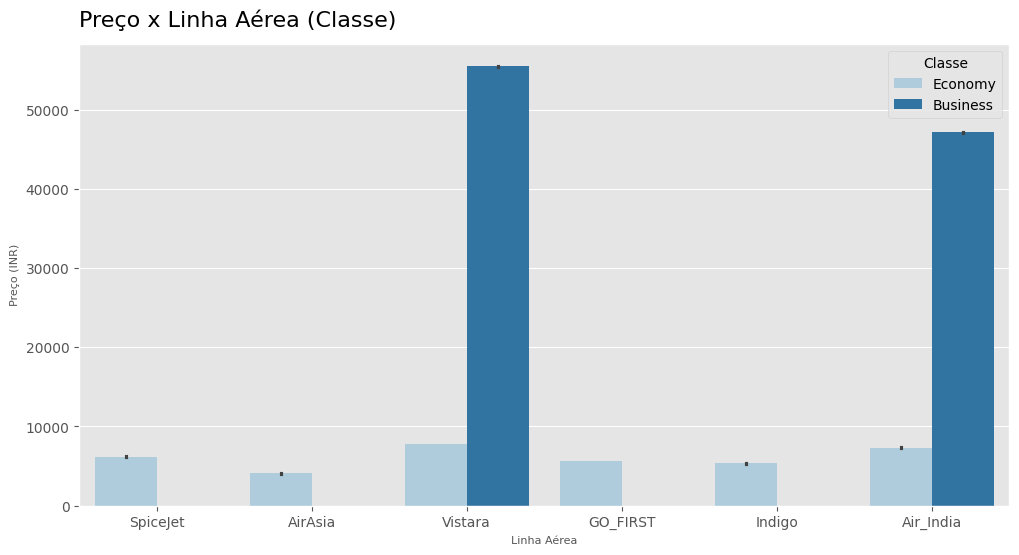

In [100]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df, x = df.airline, y = df.price, hue = df['class'], palette='Paired')
ax.set_title('Preço x Linha Aérea (Classe)', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Linha Aérea', fontsize = 8)
ax.set_ylabel('Preço (INR)', fontsize = 8)
plt.legend(title = 'Classe')
plt.show()

Vistara e Air India são as únicas empreas que oferecem o voos de classe Executiva e por isso tem os maiores valores de passagem aérea. 

#### 2. Como os preços das passagens são afetados entre 1 e 2 dias antes da viagem?

In [101]:
def maior(i):
    if i > 2:
        return 'Mais de 2 dias'
    else:
        return 'Menos de 2 dias'

In [102]:
df_days = df.copy()
df_days['days'] = df['days_left'].apply(maior)

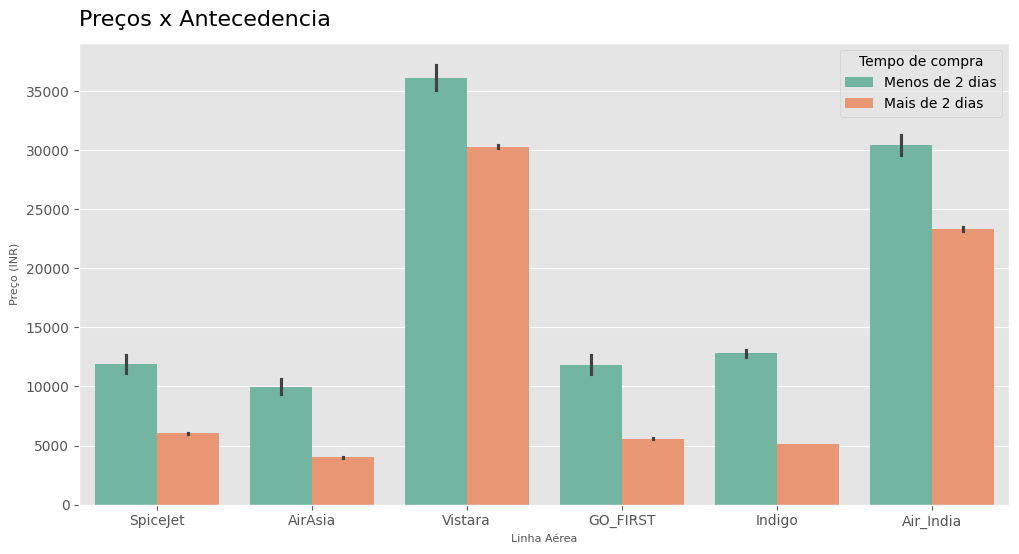

In [103]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df_days, x = df_days.airline, y = df_days.price, hue = df_days.days)
ax.set_title("Preços x Antecedencia", loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel("Linha Aérea", fontsize = 8)
ax.set_ylabel("Preço (INR)", fontsize = 8)
plt.legend(title = 'Tempo de compra')
plt.show()

O preço de passagem aéreas tem tendência de serem maiores quanto mais próximo do voo.

#### 3. O preço muda de acordo com o período do dia para chegada e partida?

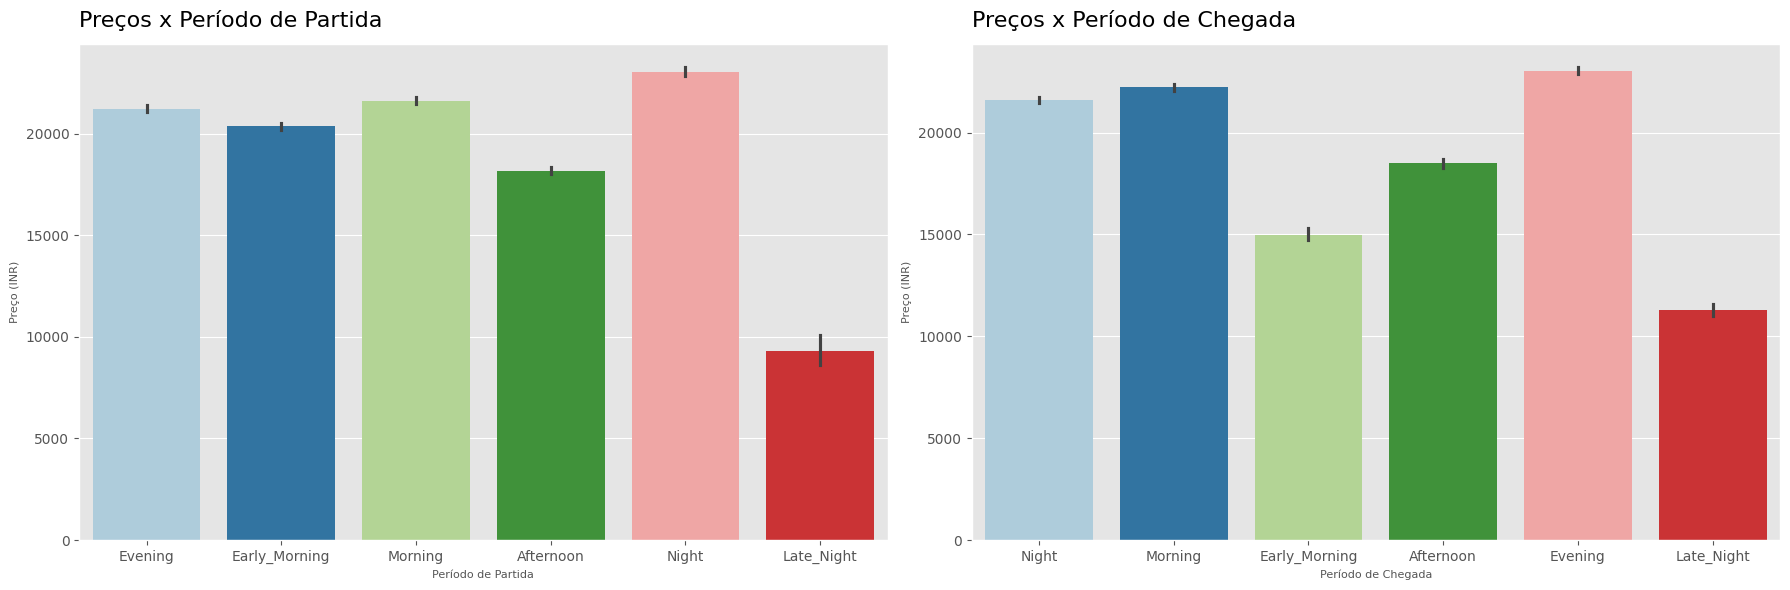

In [104]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

sns.barplot(ax = axes[0], data = df, x = df.departure_time, y = df.price, palette = 'Paired')
axes[0].set_title("Preços x Período de Partida", loc = 'left', fontsize = 16, pad = 12)
axes[0].set_xlabel("Período de Partida", fontsize = 8)
axes[0].set_ylabel("Preço (INR)", fontsize = 8)

sns.barplot(ax = axes[1], data = df, x = df.arrival_time, y = df.price, palette = 'Paired')
axes[1].set_title("Preços x Período de Chegada", loc = 'left', fontsize = 16, pad = 12)
axes[1].set_xlabel("Período de Chegada", fontsize = 8)
axes[1].set_ylabel("Preço (INR)", fontsize = 8)

plt.tight_layout()
plt.show()

A madrugada é o período onde se encontra as passagens mais baratas, já os voos a noite são os mais caros tanto para chegada quanto para partida. 

#### 4. O preço muda de acordo com o destino de partida e chegada?

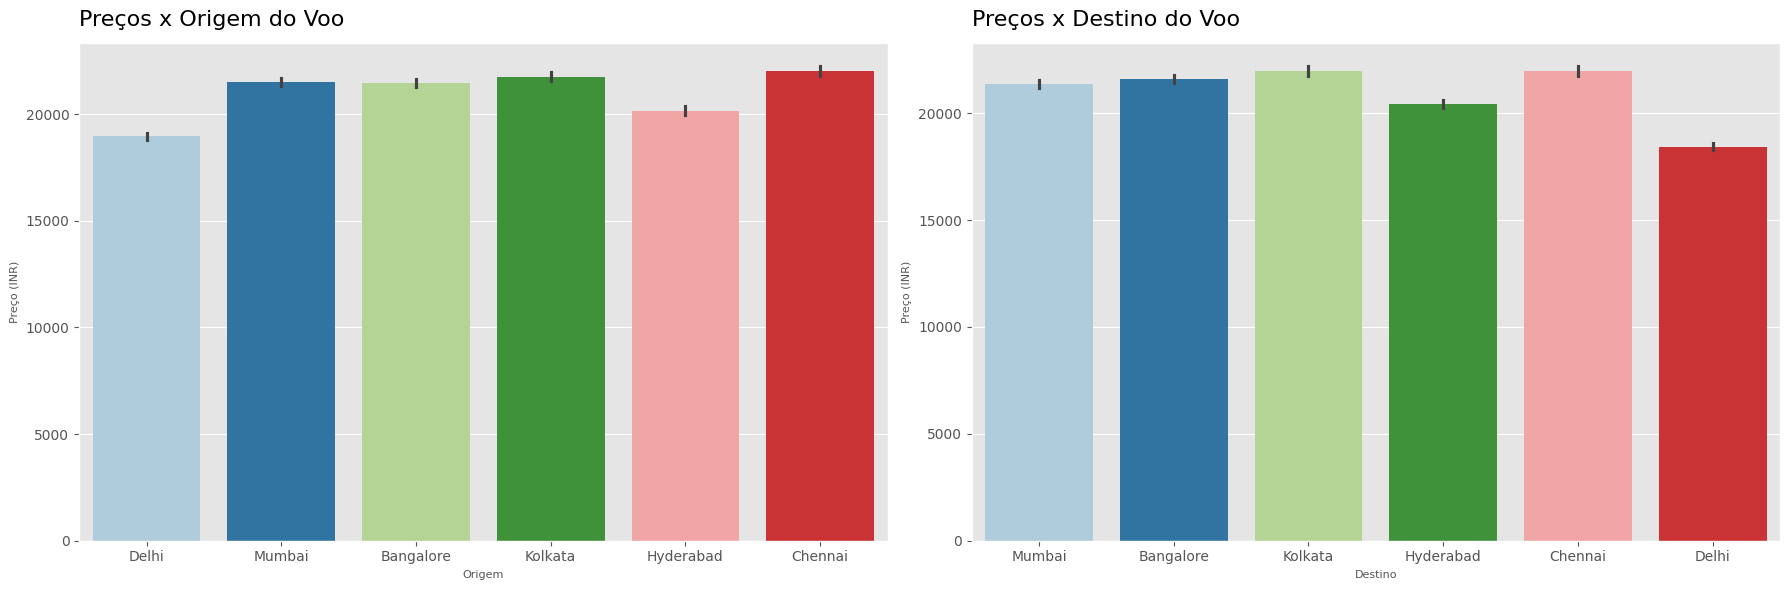

In [105]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

sns.barplot(ax = axes[0], data = df, x = df.source_city, y = df.price, palette = 'Paired')
axes[0].set_title("Preços x Origem do Voo", loc = 'left', fontsize = 16, pad = 12)
axes[0].set_xlabel("Origem", fontsize = 8)
axes[0].set_ylabel("Preço (INR)", fontsize = 8)

sns.barplot(ax = axes[1], data = df, x = df.destination_city, y = df.price, palette = 'Paired')
axes[1].set_title("Preços x Destino do Voo", loc = 'left', fontsize = 16, pad = 12)
axes[1].set_xlabel("Destino", fontsize = 8)
axes[1].set_ylabel("Preço (INR)", fontsize = 8)

plt.tight_layout()
plt.show()

Sim, os pontos de partida e destino tem influência no preço. Delhi é o destino mais barato, seguido por Hyderabad.

## 3.4. Matriz de correlação

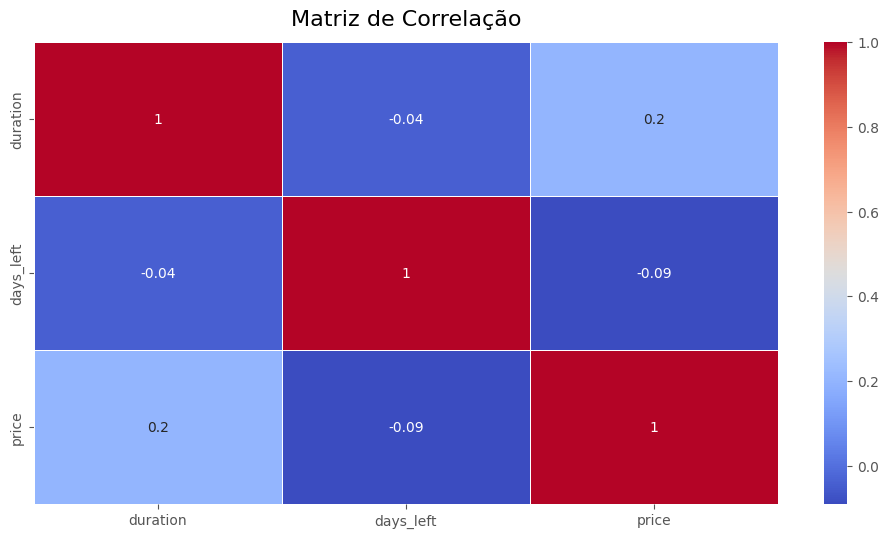

In [106]:
corr = df.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, annot = True, linecolor='white', linewidths=0.5, cmap = 'coolwarm')
ax.set_title('Matriz de Correlação', fontsize = 16, pad = 12)
plt.show()

# 4. Preparação dos dados

## 4.1. Seleção das features

In [107]:
features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left']
target = 'price'

X = df[features]
y = df[target]

In [108]:
cat_features = X.select_dtypes(include = 'object').columns.to_list()
num_features = X.select_dtypes(include = 'number').columns.to_list()

## 4.2. Pipeline do Modelo

In [109]:
num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median')),
])

cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('ohe', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [110]:
# Instanciando o modelo
model = XGBRegressor()

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# 5. Treinamento e avaliação do modelo

## 5.1. Divisão dos dados em treino e teste

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [112]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(240122, 9) (60031, 9) (240122,) (60031,)


## 5.2. Treinamento e previsões

In [113]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['duration', 'days_left']),
                                                 ('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class'])])),...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [114]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

## 5.3. Métricas do modelo

In [115]:
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [116]:
print("Métricas do Modelo")
print("=" * 50)
print(f'Mean Squared Error em Treino: {mse_train}')
print(f'Mean Squared Error em Teste: {mse_test}')
print("-" * 50)
print(f'R2 Score em Treino: {r2_train}')
print(f'R2 Score em Teste: {r2_test}')

Métricas do Modelo
Mean Squared Error em Treino: 11145408.12820081
Mean Squared Error em Teste: 12075182.899334814
--------------------------------------------------
R2 Score em Treino: 0.9783631563186646
R2 Score em Teste: 0.9765749573707581


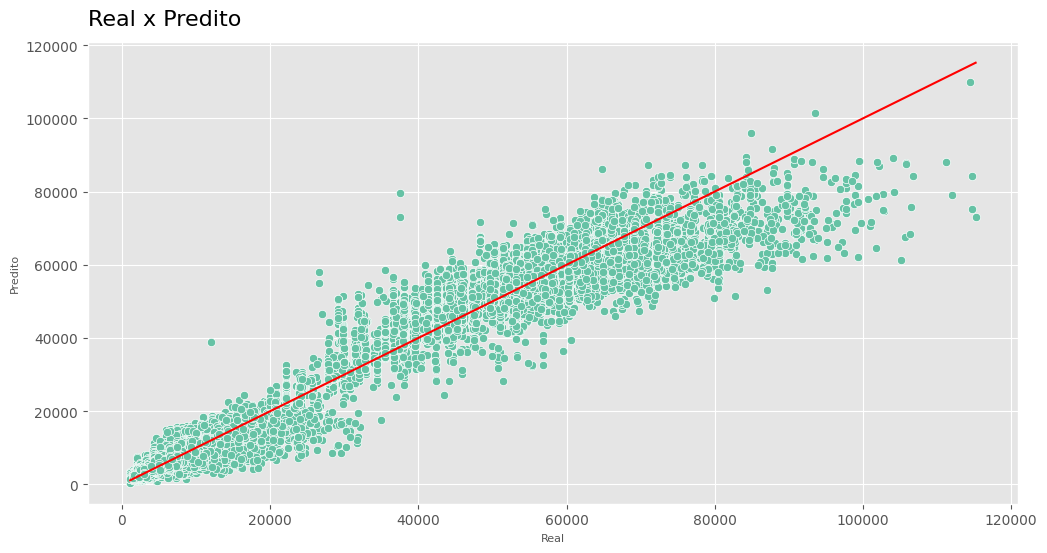

In [117]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred_test)
ax.set_title('Real x Predito', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Real', fontsize = 8)
ax.set_ylabel('Predito', fontsize = 8)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
plt.show()

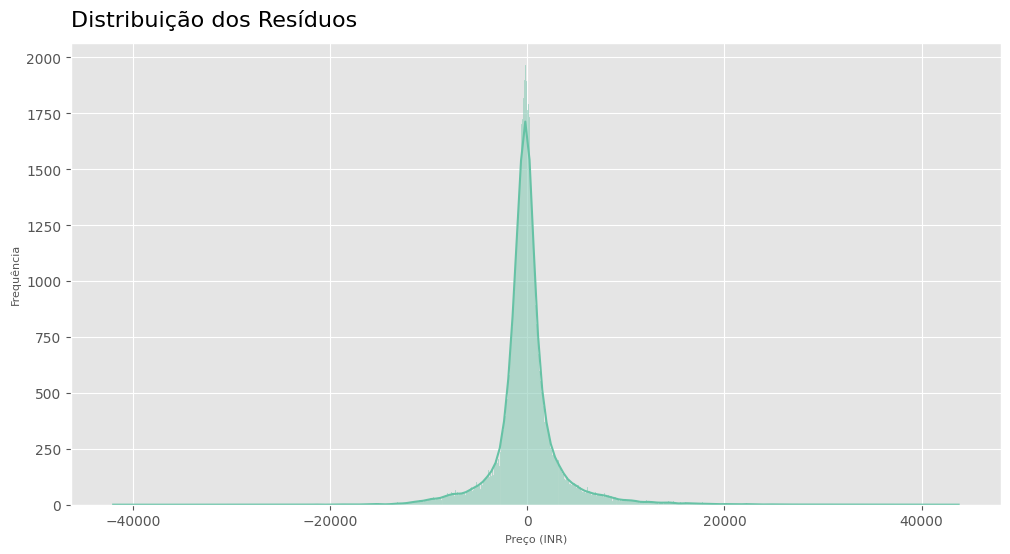

In [118]:
residuo = y_test - y_pred_test

fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(residuo, kde = True)
ax.set_title('Distribuição dos Resíduos', loc = 'left',fontsize = 16, pad = 12)
ax.set_xlabel('Preço (INR)', fontsize = 8)
ax.set_ylabel('Frequência', fontsize = 8)
plt.show()